### Integrantes: Patricio Canales, Victor Moya, Eleazar Vásquez

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

# Mi primera Red Neuronal Bayesiana

Las redes neuronales son modelos del estado del arte para hacer regresión y clasificación con datos complejos

Generalmente estos modelos requieren de una gran cantidad de datos para poder entrenarlos de forma efectiva y sin que se sobreajusten. Sin embargo, en algunos problemas los datos disponibles son simplemente muy escasos o muy difíciles de obtener. Adicionalmente, no es directo tomar decisiones en base al modelo, y se requiere un paso adicional de calibración. ¿Cómo podemos confiar en las decisiones del modelo?

Podemos intentar solucionar estos problemas escribiendo la red neuronal como un modelo bayesiano y aprender el posterior de sus parámetros con un método de Markov Chain Monte Carlo (siempre y cuando el modelo sea simple). 

Incorporando priors el modelo estará regularizado y en lugar de estimadores puntuales tendremos la distribución a posteriori completa. Esta rica información extra nos permite medir la confianza del modelo sobre sus predicciones (el modelo sabe cuando no sabe) facilitando la tarea de calibración. 



## Formulación clásica

En esta tarea se pide que programen un modelo de red neuronal para clasificación de datos bidimensionales, de dos clases, con una capa oculta y con función de activación sigmoidal

Sea el conjunto de datos y etiquetas

$$
\mathcal{D} = \{(x, y)^{(i)}, i=1,2,\ldots,N\} \quad x^{(i)} \in \mathbb{R}^2,  y^{(i)} \in \{0, 1\}
$$

Consideremos ahora una tupla en particular $(X, Y)$. La salida de la capa oculta en notación matricial es

$$
Z = \text{sigmoide}( W_Z X + B_Z)
$$

donde $W_Z \in \mathbb{R}^{M \times 2}$, $B_Z \in \mathbb{R}^{M}$ y  $M$ es el tamaño de la capa oculta

La salida de la capa visible (última capa) en notación matricial es

$$
Y = \text{sigmoide}( W_Y Z + B_Y)
$$

donde $W_Y \in \mathbb{R}^{1 \times M}$, $B_Z \in \mathbb{R}$

La función sigmoide se define como

$$
\text{sigmoide}(x) = \frac{1}{1+ e^{-x}}
$$

Luego $Z$ es un vector de largo $M$ con valores en $[0, 1]$ e $Y$ es un escalar con valor en el rango $[0, 1]$

## Formulación bayesiana

Para darle un toque bayesiano a este modelo debemos

- Definir priors para $W_Z$, $B_Z$, $W_Y$ y $B_Y$. Se pide que utilice priors **normales con media cero y desviación estándar diez**.
- Definir una verosimilitud para le problema. Dado que el problema es de clasificación binaria, utilice una distribución de **Bernoulli** con $p=Y$
- Considere los datos $X$ como una variable determínista. 

## Indicaciones

Utilice

- El atributo `shape` para darle la dimensión correcta a cada variable cada uno
- El atributo `observed` para asignar las etiquetas reales a esta variable aleatoria observada
- `pm.Data` para la variable independiente
- `theano.tensor.sigmoid` para calcular la función sigmoide
- `A.dot(B)` para calcular el producto matricial entre `A` y `B`



## Instrucciones específicas

- Considere el dataset sintético `two-moons` que se muestra a continuación. Se pide que realice dos experimentos variando el valor de `n_samples`, primero a $100$ y finalmente a $10$
- Implemente el modelo de red neuronal bayesiana en `pymc3` dejando $M$ como un argumento. Para cada valor de `n_samples` entrene tres modelos con $M=1$, $M=3$ y $M=10$
- Seleccione y calibre un algoritmo de MCMC para entrenar este modelo. Justifique y respalde sus decisiones en base al comportamiento de las trazas, al estadístico Gelman-Rubin y a la función de autocorrelación
- Estudie el posterior de los parámetros y evalue el posterior predictivo sobre los datos de prueba. Muestre graficamente la media y la varianza del posterior predictivo en el espacio de los datos. Haga observaciones y comparaciones entre los 6 casos (3 valores de $M$ y 2 valores de `n_samples`)

## Imports y creación de datos

In [ ]:
!pip3 install pygdm2

In [ ]:
!pip3 install arviz
!pip3 install pymc3==3.8

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from warnings import filterwarnings
filterwarnings("ignore")

## Genera y dibuja datos

In [4]:
def genera_datos(n_samples):
  x, y = make_moons(n_samples, # Varie este parámetro
                  shuffle=True, noise=0.2, random_state=123456)
  x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)

  return x,y

In [5]:
def dibuja_datos(x,y):
  fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
  ax.scatter(x[y==0, 0], x[y==0, 1], marker='o')
  ax.scatter(x[y==1, 0], x[y==1, 1], marker='x')

  x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), 
                      np.linspace(-3, 3, 100))
  x_test = np.vstack([x1.ravel(), x2.ravel()]).T
  fig.show()


# Datos de prueba

In [96]:
  x1, x2 = np.meshgrid(np.linspace(-3, 3, 100), 
                      np.linspace(-3, 3, 100))
  x_test = np.vstack([x1.ravel(), x2.ravel()]).T

  

## Red Neuronal Bayesiana con PyMc3





In [7]:
def construct_nn(X_shared,Y_shared, M):
    
  init_bz=np.random.randn(1, M)
  init_wz=np.random.randn(2, M)
  init_by=np.random.randn()
  init_wy=np.random.randn(M, 1)

  with pm.Model() as neural_network:
        
    X = pm.Data("x", X_shared)
    Y = Y_shared
  
    # priors
    bz = pm.Normal('bz', mu=0, sd=10, shape=(M))
    wz = pm.Normal('wz', mu=0, sd=10, shape=(2, M))
    by = pm.Normal('by', mu=0, sd=10, shape=() )
    wy = pm.Normal('wy', mu=0, sd=10, shape=(M,))
 
    # Salida de la capa oculta
    Y_final= pm.Deterministic('yf', T.nnet.sigmoid(T.dot(T.nnet.sigmoid(T.dot(X,wz) + bz),wy) + by))
    #
    # Verosimilitud con distribucion Bernoulli
    out = pm.Bernoulli("out", p=Y_final, observed=Y)

  return neural_network


# Generacion de datos

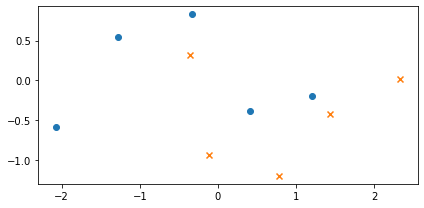

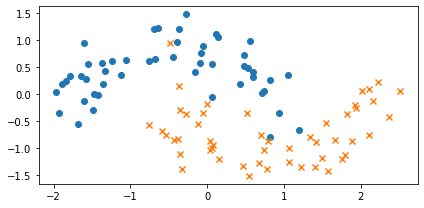

In [27]:
x_10, y_10 = genera_datos(10)
dibuja_datos(x_10,y_10)
x_100, y_100 = genera_datos(100)
dibuja_datos(x_100,y_100)

# Entremamiento de modelo Sample=10, M=1

In [28]:
neural_network_s10_M1 = construct_nn(x_10,y_10,1)

In [29]:
with neural_network_s10_M1:
  trace_10_1 = pm.sample(draws=4000, tune=2500,cores=2,chains=4, step=pm.NUTS(target_accept=0.9));

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [02:04<00:00, 209.28draws/s]
The number of effective samples is smaller than 10% for some parameters.


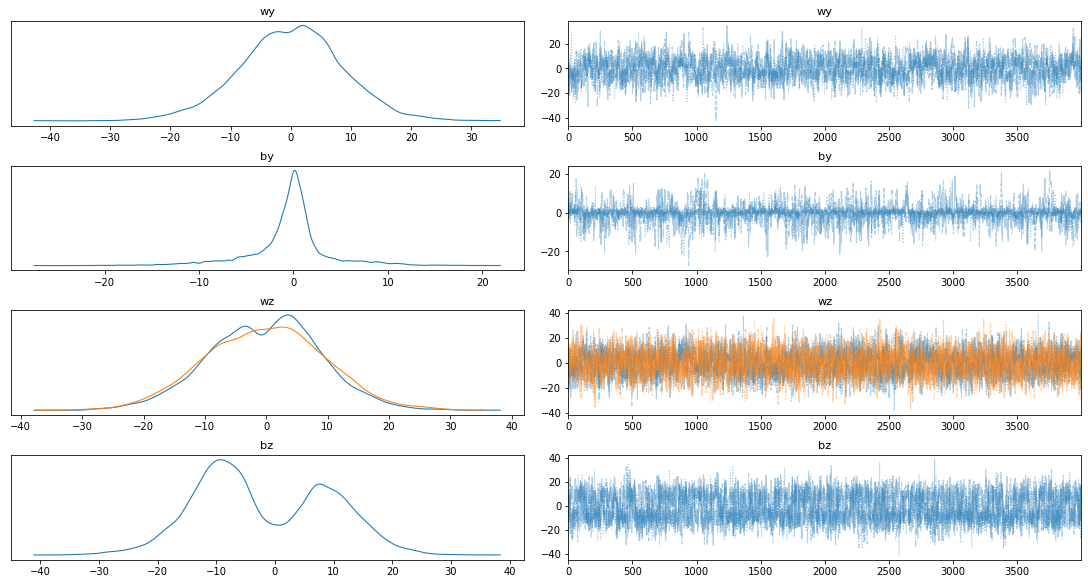

In [30]:
pm.traceplot(trace_10_1, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

In [31]:
pm.summary(trace_10_1, var_names=['bz', 'wz', 'by', 'wy']).round(3)

mean      sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
bz[0]   -1.870  11.330 -20.575   17.845  ...  1629.0    1828.0    5399.0   1.01
wz[0,0] -0.233   9.103 -17.185   17.032  ...  1427.0    1435.0    4519.0   1.00
wz[1,0] -0.169   9.755 -18.450   17.710  ...  1237.0    1242.0    4246.0   1.00
by      -0.416   4.159  -9.513    8.717  ...  1140.0    1050.0    1500.0   1.00
wy[0]    0.018   8.684 -16.079   16.649  ...  1006.0     992.0    2860.0   1.00

[5 rows x 11 columns]

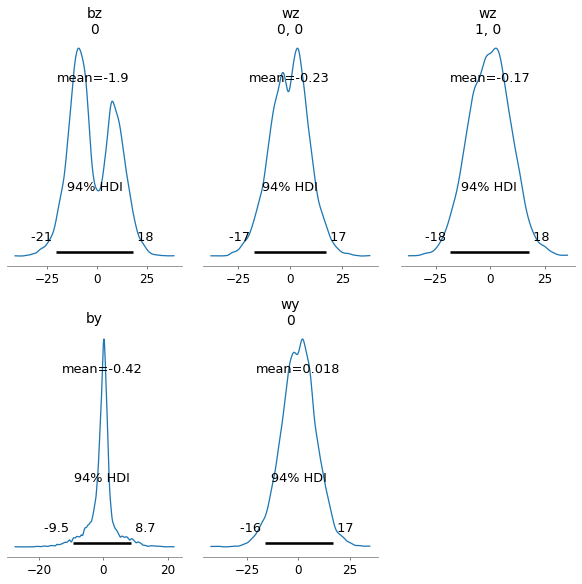

In [32]:
pm.plot_posterior(trace_10_1, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

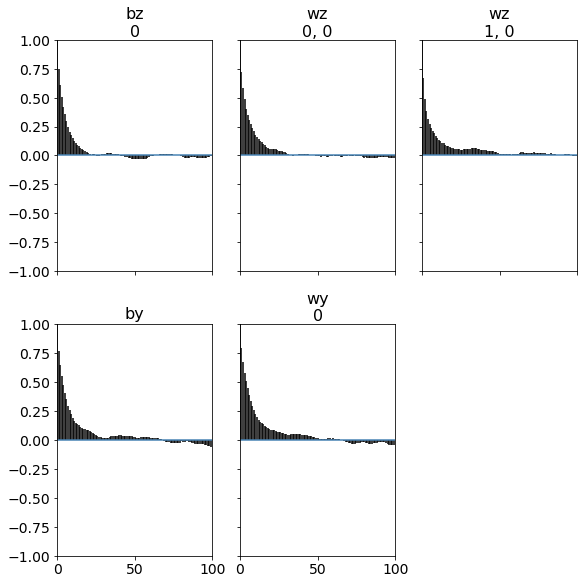

In [33]:
pm.plots.autocorrplot(trace_10_1, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# Sample=10, M=3

In [35]:
neural_network_s10_M3 = construct_nn(x_10,y_10,3)

In [36]:
with neural_network_s10_M3:
  trace_10_3 = pm.sample(draws=4000, tune=2000,cores=2,chains=2, step=pm.NUTS(target_accept=.99))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [04:23<00:00, 45.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


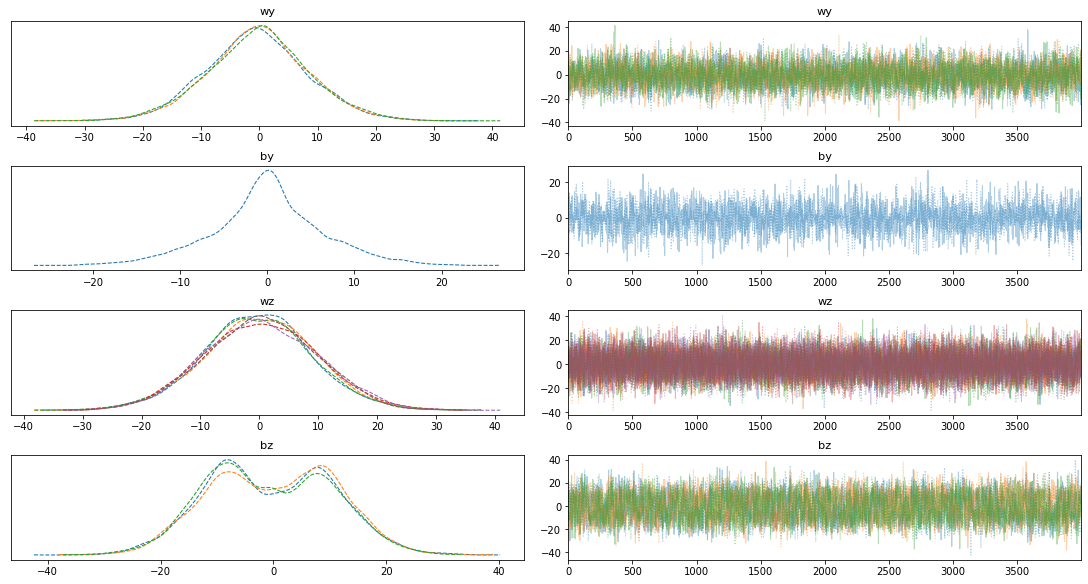

In [37]:
pm.traceplot(trace_10_3, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

In [38]:
pm.summary(trace_10_3, var_names=['bz', 'wz', 'by', 'wy']).round(3)

mean      sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
bz[0]   -0.574  11.143 -19.738   19.699  ...  1184.0    1262.0    4126.0    1.0
bz[1]    0.109  11.155 -20.283   18.646  ...  1498.0    1590.0    4020.0    1.0
bz[2]   -0.847  11.122 -20.119   18.813  ...  1255.0    1349.0    4167.0    1.0
wz[0,0] -0.369   9.109 -18.254   16.678  ...  1910.0    1897.0    3725.0    1.0
wz[0,1]  0.180   9.429 -17.542   17.903  ...  1765.0    1761.0    4083.0    1.0
wz[0,2] -0.583   9.427 -17.750   18.093  ...  1991.0    1976.0    3923.0    1.0
wz[1,0]  0.184   9.744 -17.853   18.355  ...  2844.0    2851.0    5230.0    1.0
wz[1,1]  0.377   9.770 -17.719   18.582  ...  2654.0    2662.0    4056.0    1.0
wz[1,2]  0.292   9.452 -17.194   17.863  ...  2594.0    2603.0    4752.0    1.0
by      -0.032   6.535 -13.532   12.438  ...  2312.0    2269.0    3429.0    1.0
wy[0]   -0.495   8.680 -16.602   15.921  ...  1515.0    1511.0    2937.0    1.0
wy[1]   -0.182   8.693 -17.403   15.971  ...  1735.0    1716.0    3615.0    1.0
wy[2]   -0.182   8.846 -17.469   16.513  ...  1869.0    1851.0    3423.0    1.0

[13 rows x 11 columns]

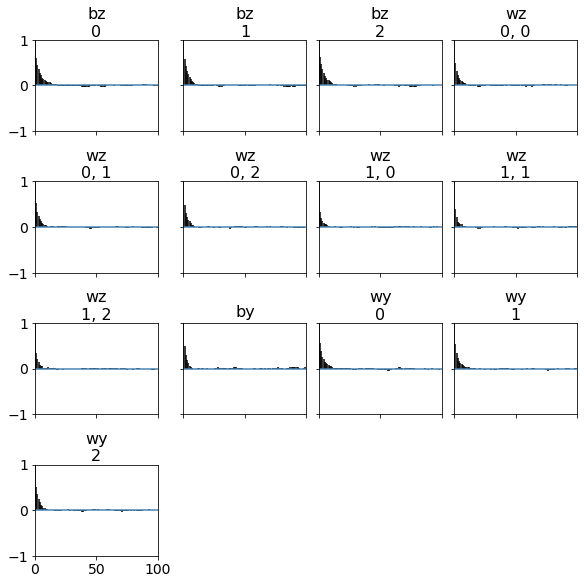

In [39]:
pm.plots.autocorrplot(trace_10_3, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# Sample=10, M=10

In [40]:
neural_network_s10_M10 = construct_nn(x_10,y_10,10)

In [41]:
with neural_network_s10_M10:
  trace_10_10 = pm.sample(draws=3000, tune=1000,cores=2,chains=2, step=pm.NUTS(target_accept=.99, max_treedepth=12))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [05:00<00:00, 26.64draws/s]


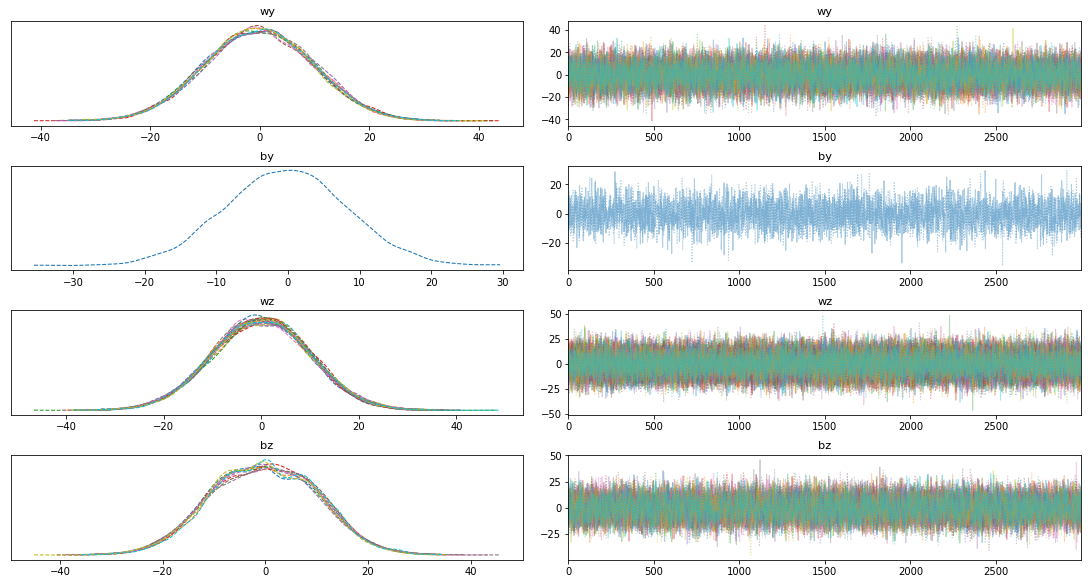

In [42]:
pm.traceplot(trace_10_10, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

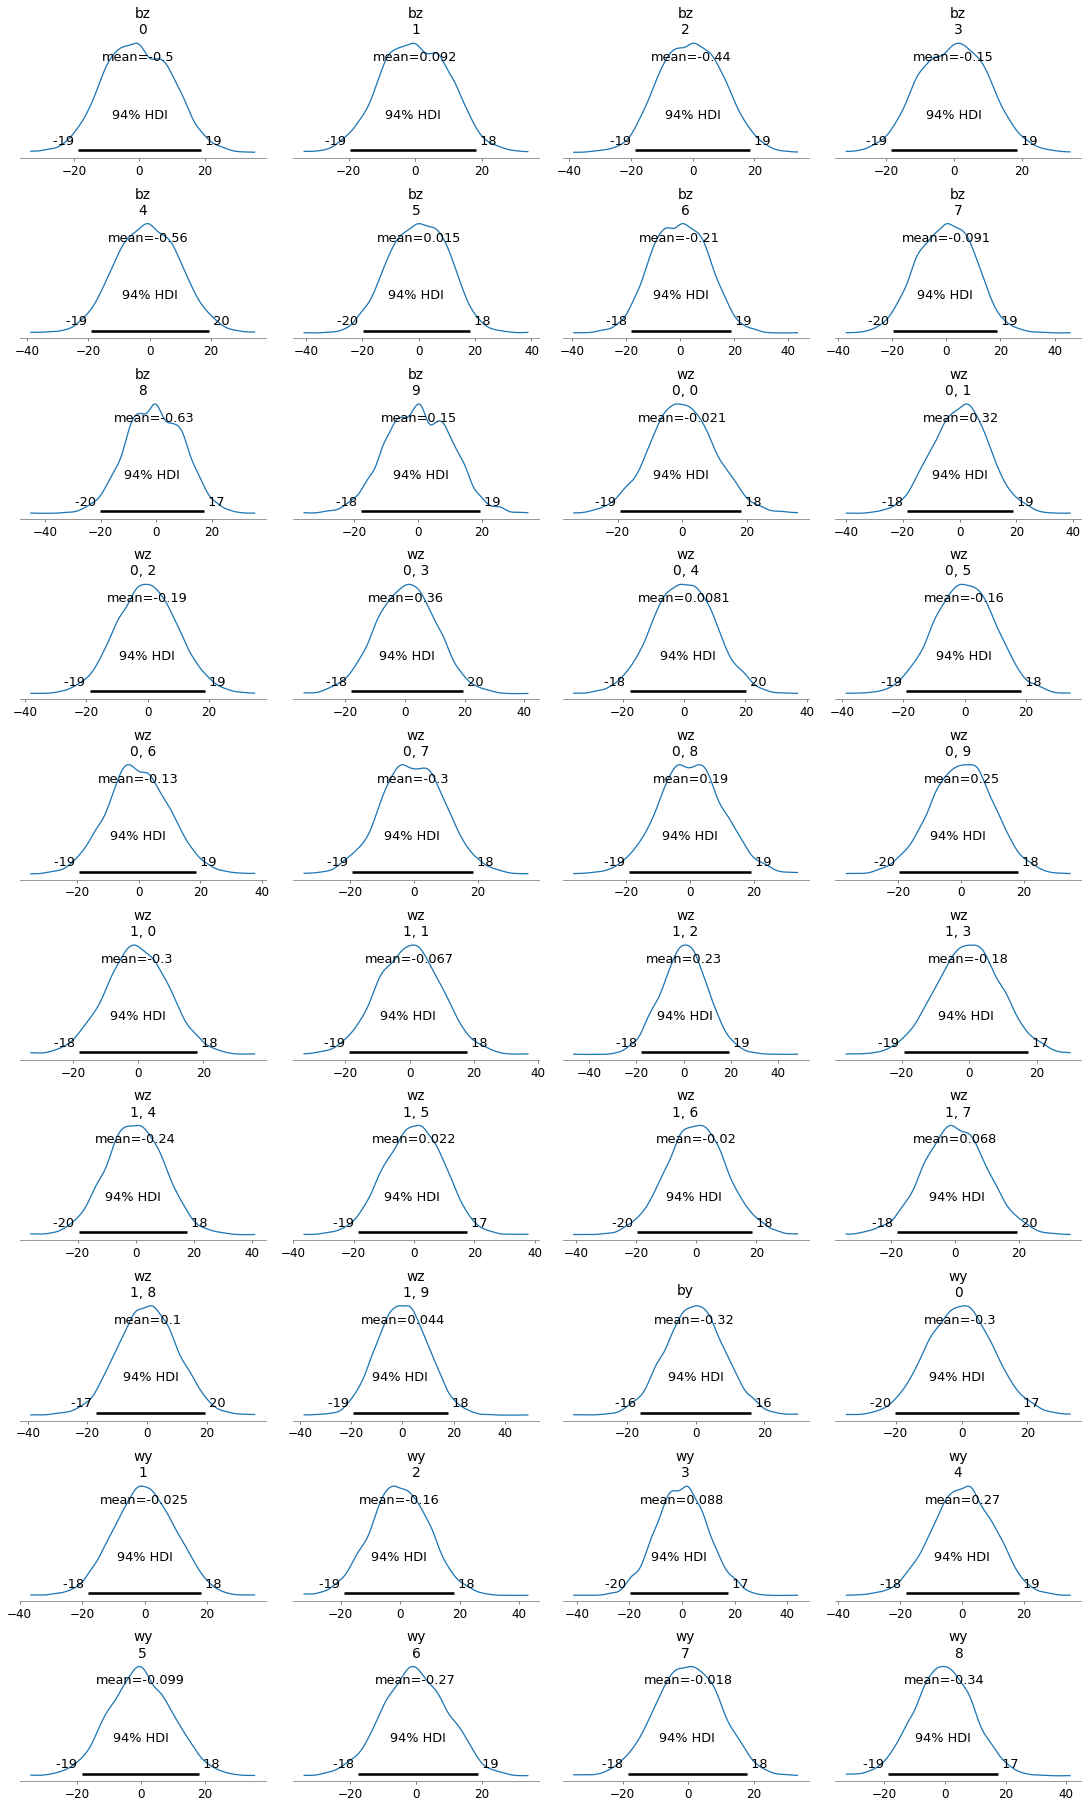

In [44]:
pm.plot_posterior(trace_10_10, figsize=(15, 25), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

In [45]:
pm.summary(trace_10_10, var_names=['bz', 'wz', 'by', 'wy']).round(3)

mean      sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
bz[0]   -0.498  10.306 -18.699   18.995  ...  2583.0    2649.0    5025.0    1.0
bz[1]    0.092  10.281 -19.419   18.239  ...  1939.0    1982.0    4290.0    1.0
bz[2]   -0.443  10.269 -18.625   18.626  ...  1910.0    1930.0    4370.0    1.0
bz[3]   -0.152  10.174 -18.739   18.625  ...  1942.0    1968.0    4205.0    1.0
bz[4]   -0.559  10.409 -19.125   19.508  ...  1920.0    1944.0    4353.0    1.0
bz[5]    0.015  10.392 -19.907   18.173  ...  2398.0    2457.0    4106.0    1.0
bz[6]   -0.207  10.314 -18.435   18.843  ...  2056.0    2099.0    3928.0    1.0
bz[7]   -0.091  10.518 -19.730   18.706  ...  2243.0    2288.0    4322.0    1.0
bz[8]   -0.632  10.188 -20.167   17.157  ...  2142.0    2182.0    4564.0    1.0
bz[9]    0.151  10.190 -17.828   19.428  ...  1967.0    2009.0    4488.0    1.0
wz[0,0] -0.021  10.086 -19.294   18.349  ...  2570.0    2569.0    4369.0    1.0
wz[0,1]  0.322   9.972 -18.427   18.959  ...  2191.0    2187.0    4305.0    1.0
wz[0,2] -0.194  10.001 -18.951   18.533  ...  2478.0    2473.0    4366.0    1.0
wz[0,3]  0.356  10.116 -18.182   19.521  ...  3179.0    3191.0    4670.0    1.0
wz[0,4]  0.008  10.103 -17.692   20.317  ...  2461.0    2472.0    3773.0    1.0
wz[0,5] -0.162  10.073 -19.035   18.369  ...  2403.0    2410.0    3971.0    1.0
wz[0,6] -0.133  10.119 -19.240   18.544  ...  2727.0    2729.0    4137.0    1.0
wz[0,7] -0.304   9.972 -19.328   18.354  ...  2596.0    2601.0    4083.0    1.0
wz[0,8]  0.194  10.153 -19.162   19.047  ...  2761.0    2757.0    4541.0    1.0
wz[0,9]  0.254   9.980 -19.558   18.032  ...  2176.0    2178.0    4137.0    1.0
wz[1,0] -0.297   9.672 -18.059   18.173  ...  3225.0    3915.0    4533.0    1.0
wz[1,1] -0.067   9.877 -18.900   17.952  ...  3669.0    3922.0    4589.0    1.0
wz[1,2]  0.229  10.009 -18.206   19.262  ...  3847.0    3852.0    4893.0    1.0
wz[1,3] -0.179   9.742 -19.457   17.373  ...  3204.0    3203.0    4122.0    1.0
wz[1,4] -0.243  10.082 -19.673   17.804  ...  3053.0    4509.0    4190.0    1.0
wz[1,5]  0.022   9.752 -18.523   17.413  ...  3593.0    3583.0    4515.0    1.0
wz[1,6] -0.020  10.028 -19.685   18.370  ...  3530.0    3956.0    4413.0    1.0
wz[1,7]  0.068  10.053 -18.228   19.583  ...  3297.0    3297.0    4009.0    1.0
wz[1,8]  0.100   9.948 -17.192   19.528  ...  3965.0    4234.0    4880.0    1.0
wz[1,9]  0.044   9.969 -19.330   17.690  ...  3474.0    3490.0    4274.0    1.0
by      -0.319   8.507 -16.027   16.114  ...  4011.0    4456.0    4861.0    1.0
wy[0]   -0.304   9.946 -20.049   17.311  ...  2640.0    2649.0    3663.0    1.0
wy[1]   -0.025   9.793 -18.047   18.122  ...  2630.0    2625.0    3974.0    1.0
wy[2]   -0.163   9.883 -18.784   18.192  ...  3037.0    3040.0    4219.0    1.0
wy[3]    0.088   9.807 -19.855   17.423  ...  2842.0    2846.0    4023.0    1.0
wy[4]    0.266   9.958 -18.212   18.522  ...  2808.0    2809.0    4148.0    1.0
wy[5]   -0.099   9.923 -18.650   18.353  ...  3132.0    3133.0    4136.0    1.0
wy[6]   -0.271   9.809 -17.638   18.793  ...  2843.0    2860.0    4665.0    1.0
wy[7]   -0.018   9.801 -18.456   17.811  ...  2746.0    2748.0    4157.0    1.0
wy[8]   -0.344   9.709 -18.781   17.388  ...  2958.0    2959.0    4039.0    1.0
wy[9]    0.088   9.833 -18.607   18.000  ...  2764.0    2765.0    4187.0    1.0

[41 rows x 11 columns]

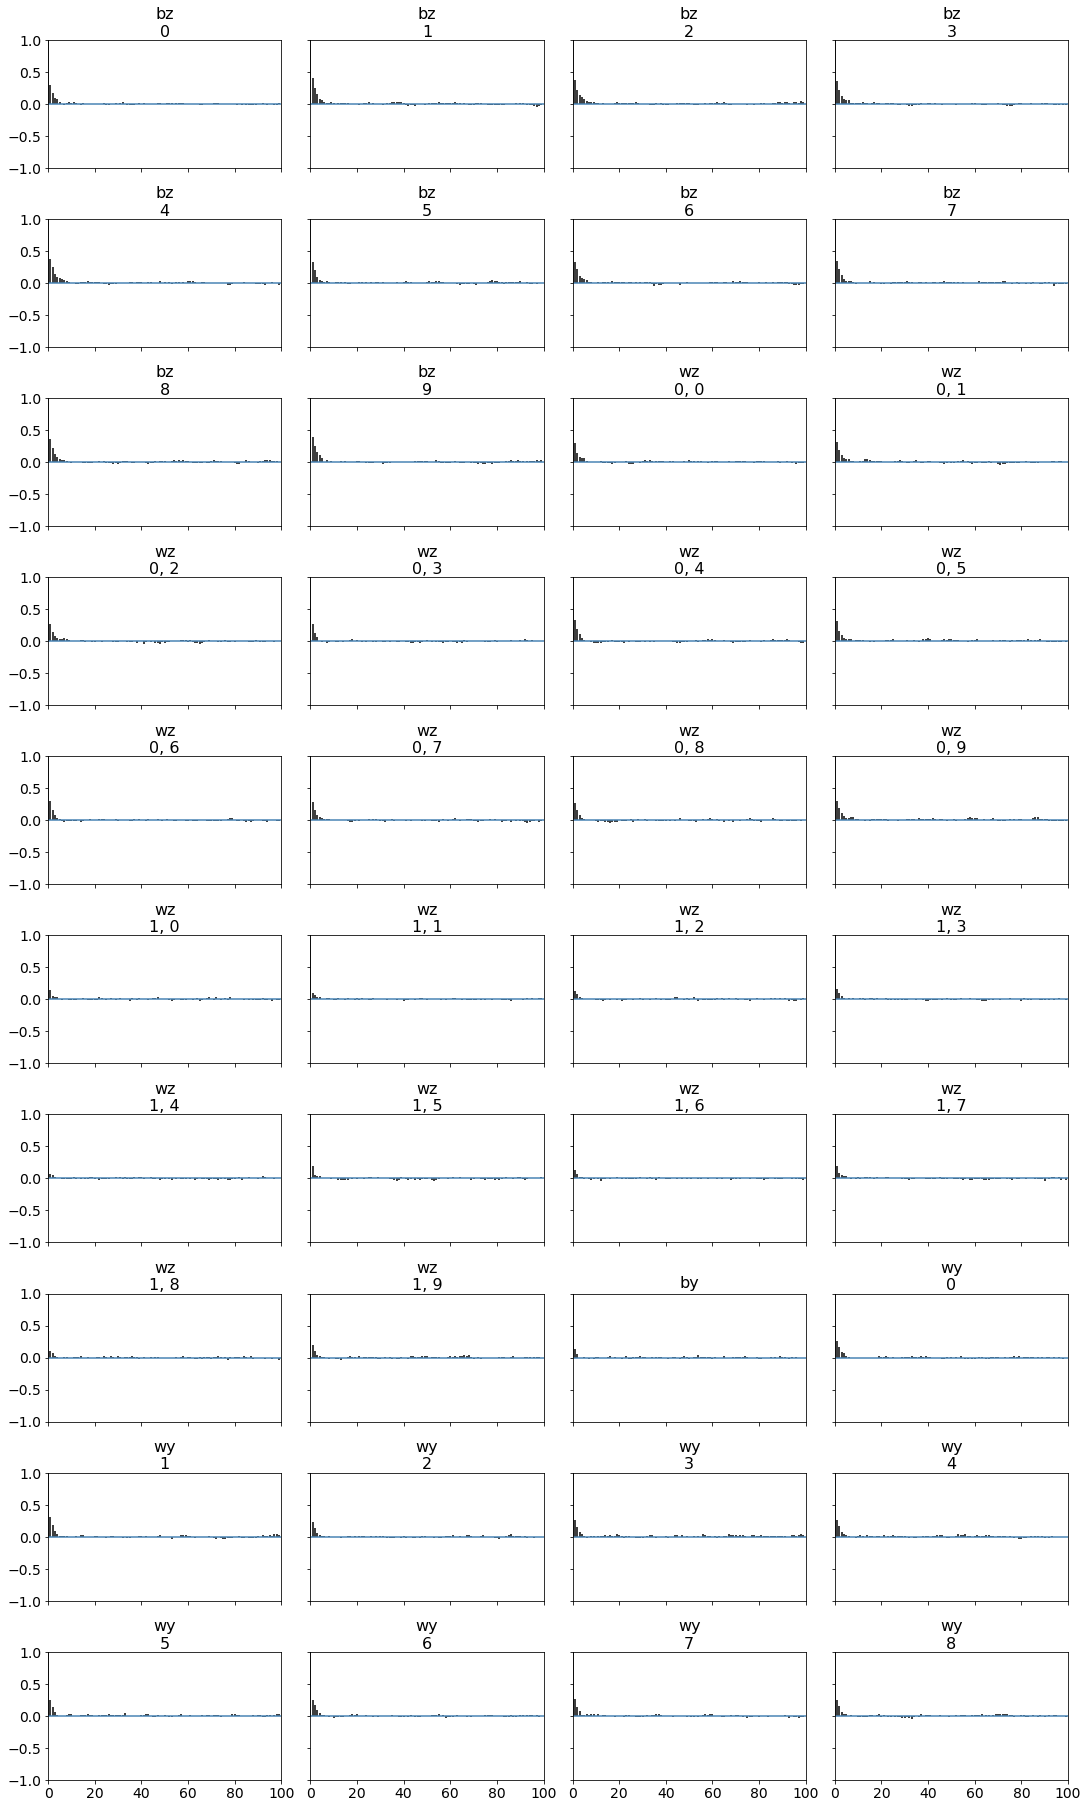

In [46]:
pm.plots.autocorrplot(trace_10_10, figsize=(15, 25), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# Sample 100, M=1

In [47]:
neural_network_s100_M1 = construct_nn(x_100,y_100,1)

In [48]:
with neural_network_s100_M1:
    trace_100_1 = pm.sample(draws=4000, tune=1500,cores=2,chains=2, step=pm.NUTS(target_accept=.99, max_treedepth=12))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 1 divergences: 100%|██████████| 11000/11000 [00:58<00:00, 189.21draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


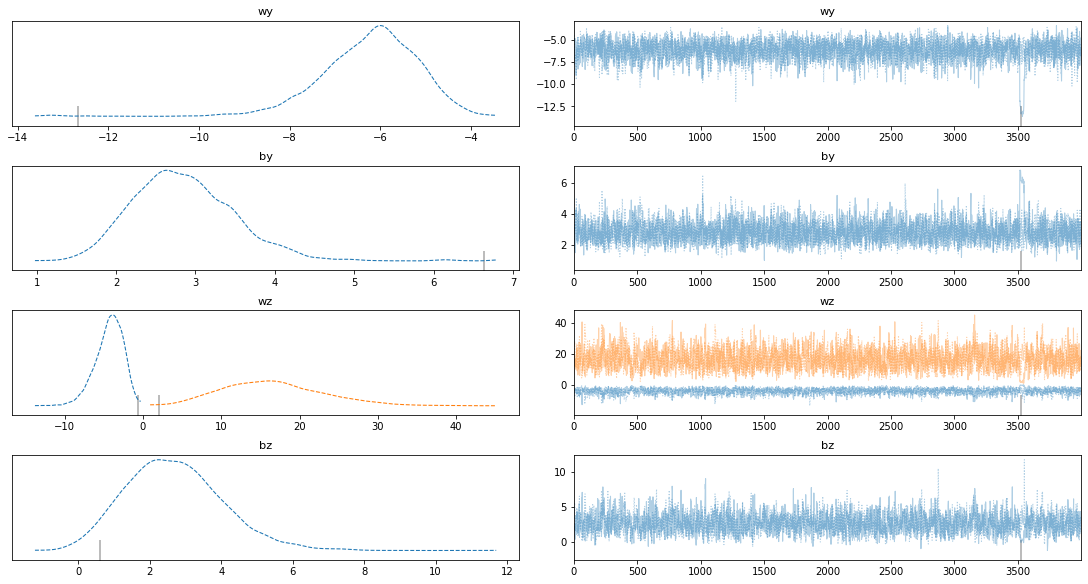

In [49]:
pm.traceplot(trace_100_1, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

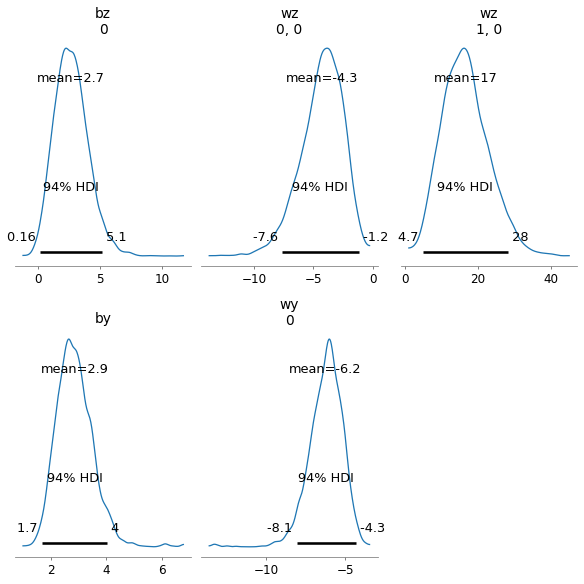

In [50]:
pm.plot_posterior(trace_100_1, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

In [51]:
pm.summary(trace_100_1, var_names=['bz', 'wz', 'by', 'wy']).round(3)

mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
bz[0]     2.676  1.357   0.162    5.110  ...  1868.0    1873.0    2073.0    1.0
wz[0,0]  -4.286  1.790  -7.649   -1.175  ...  1463.0    1359.0    1467.0    1.0
wz[1,0]  16.546  6.401   4.691   28.181  ...  1575.0    1441.0    1540.0    1.0
by        2.857  0.668   1.666    4.032  ...   745.0    2453.0    1442.0    1.0
wy[0]    -6.232  1.104  -8.079   -4.284  ...   639.0    2153.0    1469.0    1.0

[5 rows x 11 columns]

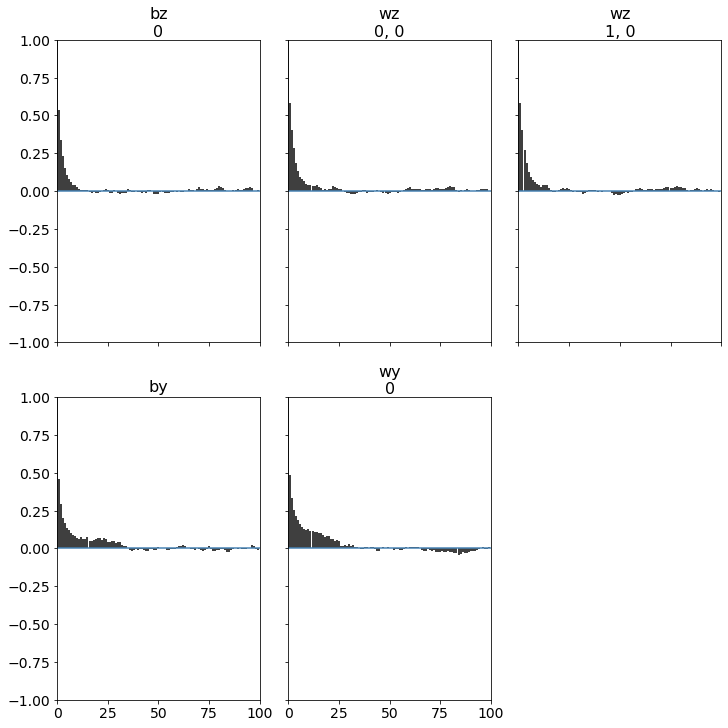

In [52]:
pm.plots.autocorrplot(trace_100_1, figsize=(10, 10), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# sample 100, M=3

In [53]:
neural_network_s100_M3 = construct_nn(x_100,y_100,3)

In [60]:
with neural_network_s100_M3:
    trace_100_3 = pm.sample(draws=3000, tune=2000,cores=2,chains=3, step=pm.NUTS(target_accept=.99, max_treedepth=10))

Multiprocess sampling (3 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 3 chains, 1 divergences: 100%|██████████| 15000/15000 [08:45<00:00, 28.52draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


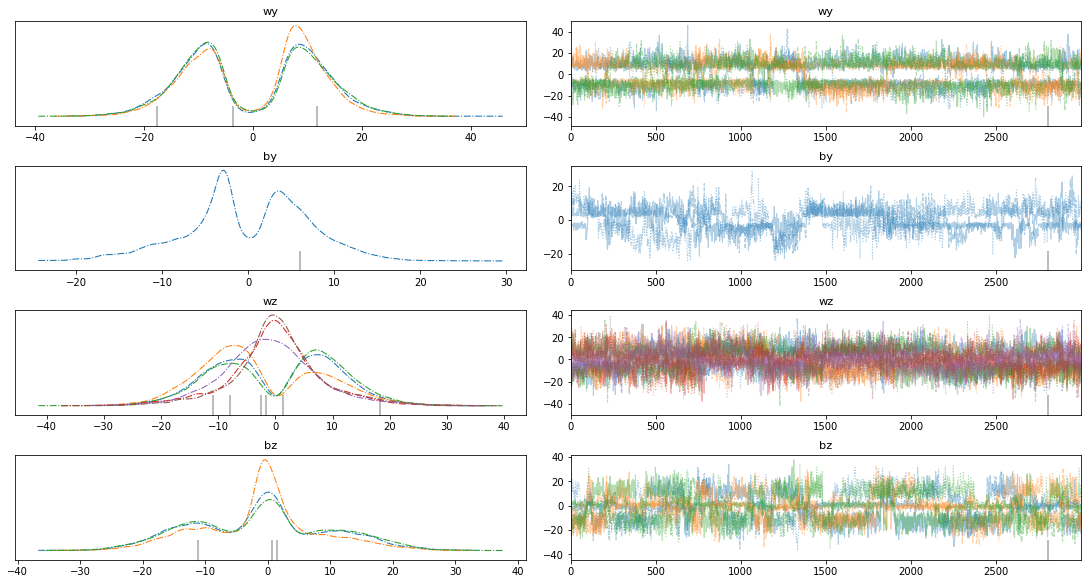

In [61]:
pm.traceplot(trace_100_3, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

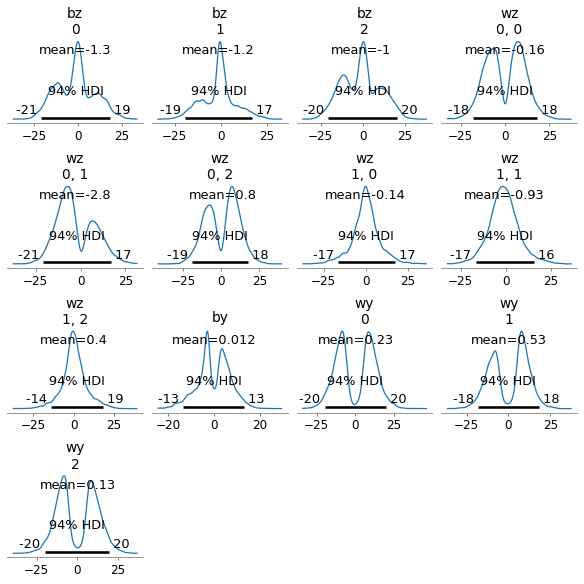

In [62]:
pm.plot_posterior(trace_100_3, figsize=(8, 8), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

In [63]:
pm.summary(trace_100_3, var_names=['bz', 'wz', 'by', 'wy']).round(3)

mean      sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
bz[0]   -1.272  10.919 -20.670   18.574  ...    13.0      14.0     113.0   1.17
bz[1]   -1.199   9.355 -19.455   17.117  ...    79.0      83.0     263.0   1.05
bz[2]   -1.015  11.306 -20.352   20.271  ...    49.0      53.0     419.0   1.06
wz[0,0] -0.159  10.531 -17.863   18.148  ...    12.0      15.0     465.0   1.14
wz[0,1] -2.824  10.670 -20.730   16.718  ...    18.0      24.0     417.0   1.12
wz[0,2]  0.798  10.872 -19.266   17.939  ...    38.0      44.0     545.0   1.05
wz[1,0] -0.136   8.299 -16.619   17.203  ...    31.0      24.0     162.0   1.10
wz[1,1] -0.931   8.337 -16.758   15.846  ...    33.0      30.0     449.0   1.10
wz[1,2]  0.400   7.820 -13.779   18.515  ...    28.0      25.0     157.0   1.09
by       0.012   7.134 -13.467   13.250  ...    76.0      80.0     187.0   1.02
wy[0]    0.233  12.166 -19.814   19.807  ...     9.0      11.0     146.0   1.21
wy[1]    0.529  11.281 -18.336   18.206  ...    23.0      28.0     191.0   1.10
wy[2]    0.130  12.143 -20.164   19.604  ...    17.0      24.0     299.0   1.10

[13 rows x 11 columns]

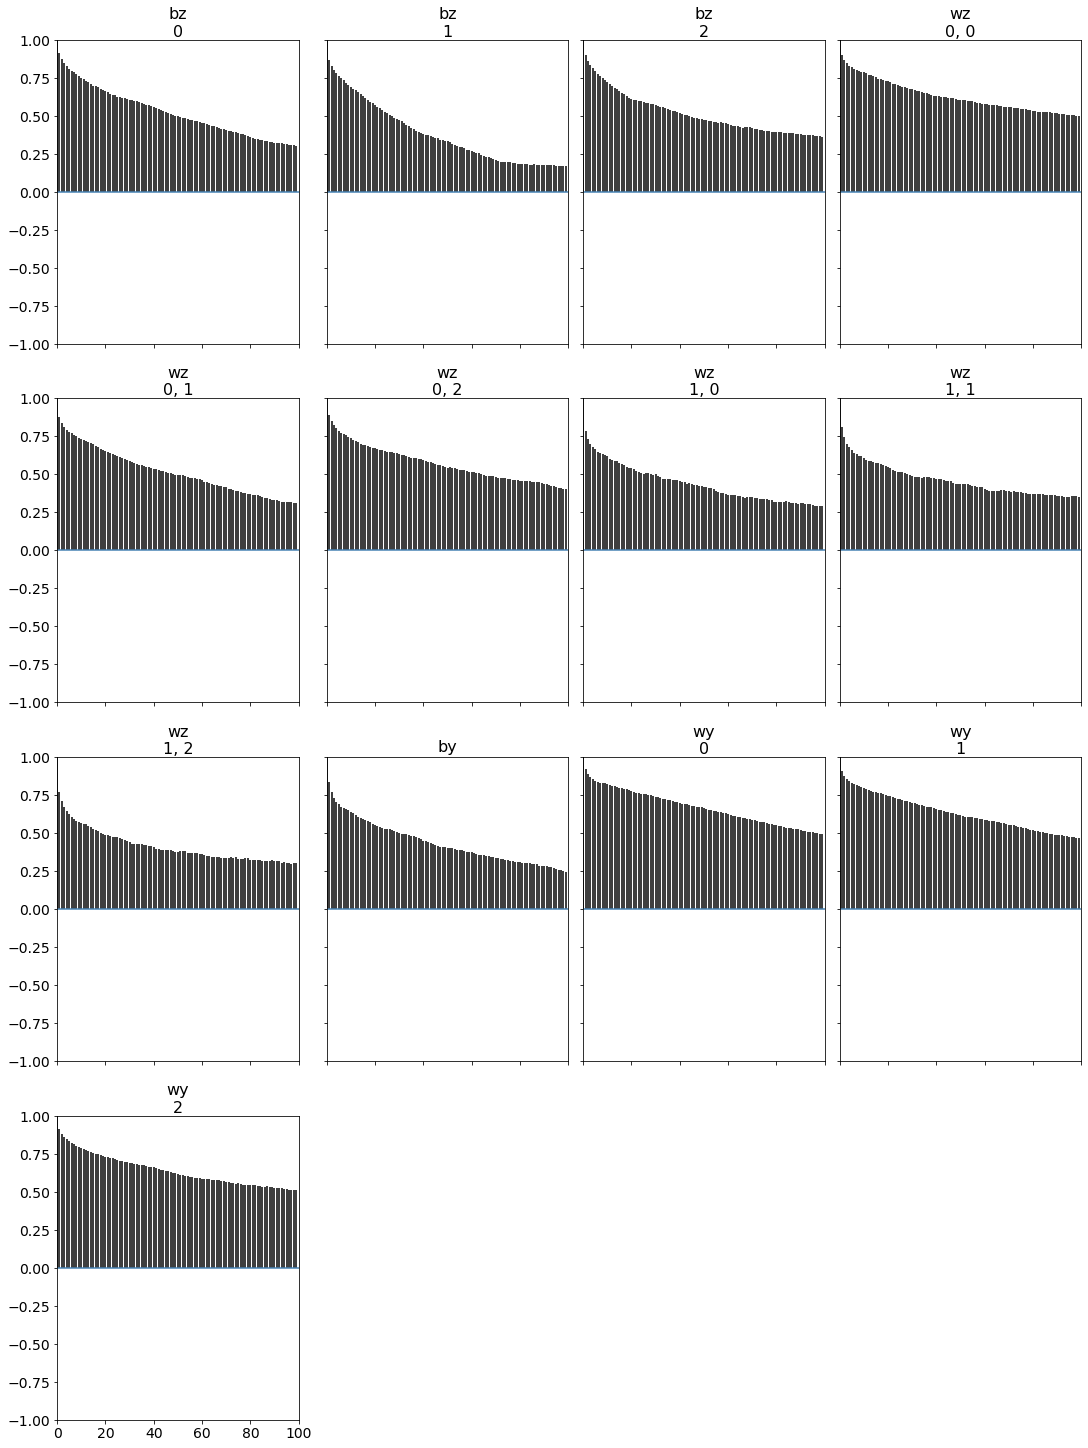

In [64]:
pm.plots.autocorrplot(trace_100_3, figsize=(15, 20), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

# sample 100, M=10

In [72]:
neural_network_s100_M10 = construct_nn(x_100,y_100,10)

In [79]:
with neural_network_s100_M10:
    trace_100_10 = pm.sample(draws=2000, tune=500,cores=2,chains=2, step=pm.NUTS(target_accept=.9))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wy, by, wz, bz]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:10<00:00, 19.95draws/s]
The number of effective samples is smaller than 25% for some parameters.


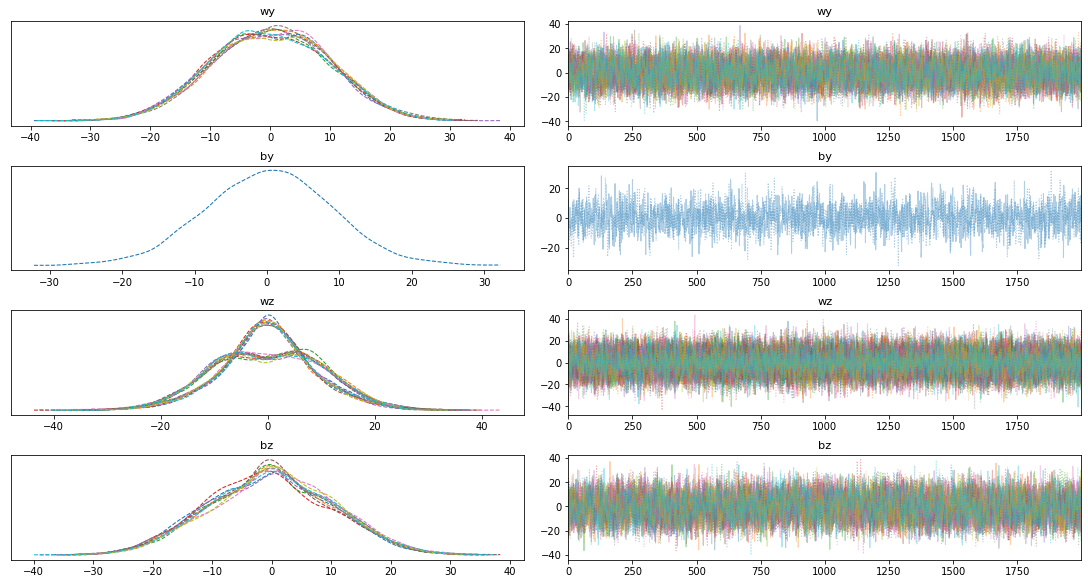

In [80]:
pm.traceplot(trace_100_10, figsize=(15, 8), var_names=['wy', 'by', 'wz', 'bz'], combined=True);

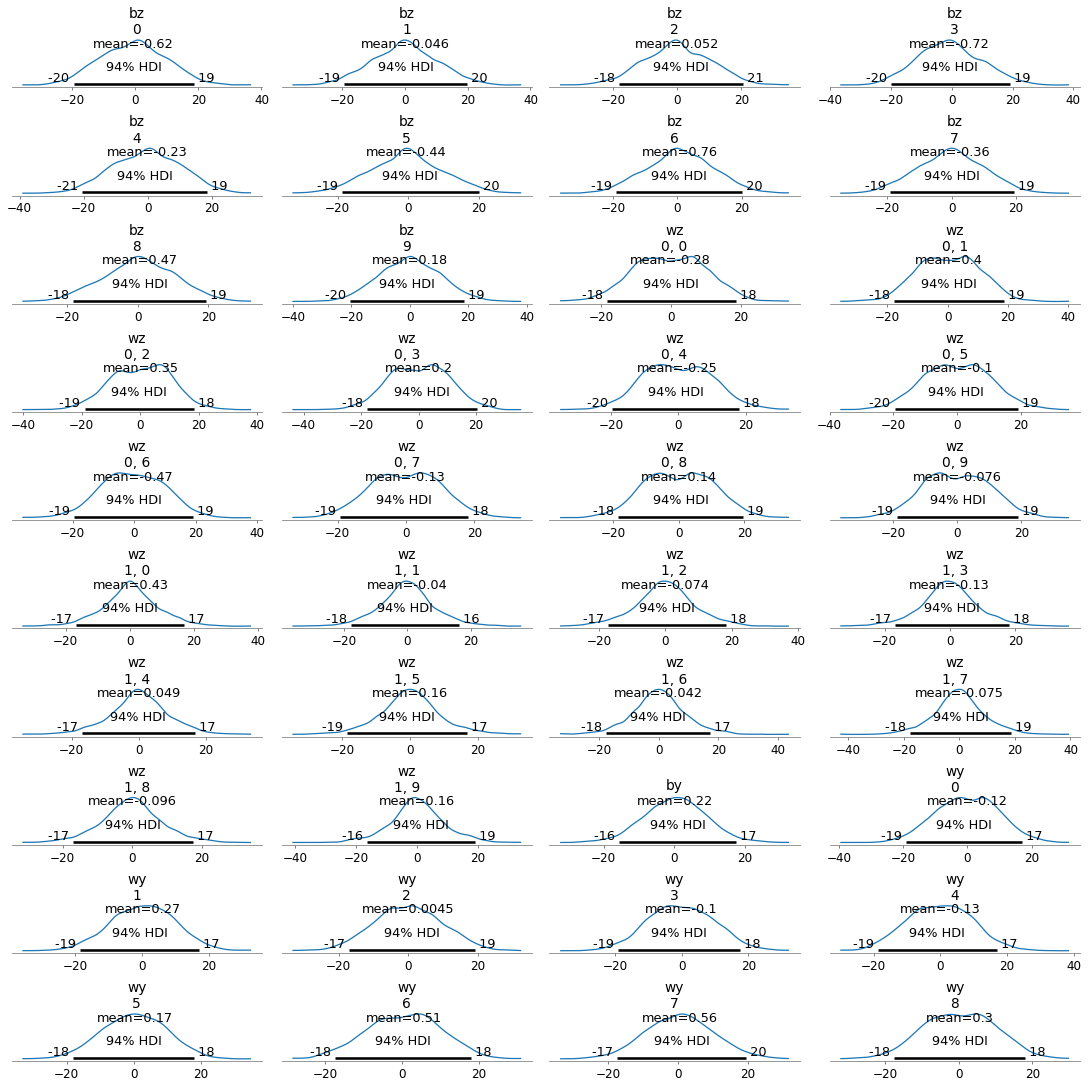

In [81]:
pm.plot_posterior(trace_100_10, figsize=(15, 15), var_names=['bz', 'wz', 'by', 'wy'], textsize=12);

In [82]:
pm.summary(trace_100_10, var_names=['bz', 'wz', 'by', 'wy']).round(3)

mean      sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
bz[0]   -0.615  10.487 -19.521   18.631  ...   755.0     767.0    2121.0   1.01
bz[1]   -0.046  10.490 -19.457   19.816  ...   657.0     663.0    2053.0   1.01
bz[2]    0.052  10.479 -18.159   20.536  ...   539.0     537.0    2103.0   1.01
bz[3]   -0.721  10.507 -19.920   19.047  ...   760.0     771.0    1862.0   1.00
bz[4]   -0.228  10.720 -20.512   18.658  ...   774.0     789.0    2545.0   1.00
bz[5]   -0.444  10.283 -18.681   19.933  ...   836.0     843.0    2332.0   1.00
bz[6]    0.760  10.505 -19.022   20.108  ...   728.0     731.0    1925.0   1.00
bz[7]   -0.356  10.369 -19.243   19.407  ...   645.0     656.0    1725.0   1.00
bz[8]    0.473  10.206 -18.495   19.450  ...   656.0     663.0    2118.0   1.00
bz[9]    0.178  10.532 -20.475   18.654  ...   736.0     740.0    1943.0   1.00
wz[0,0] -0.276  10.273 -18.379   18.410  ...   981.0    1013.0    2485.0   1.00
wz[0,1]  0.396  10.291 -17.861   18.635  ...   995.0    1009.0    2714.0   1.00
wz[0,2]  0.351  10.304 -19.017   18.352  ...   965.0    1000.0    2563.0   1.00
wz[0,3]  0.197  10.432 -18.022   20.161  ...  1062.0    1100.0    2333.0   1.00
wz[0,4] -0.248  10.324 -19.687   17.944  ...  1117.0    1143.0    2113.0   1.00
wz[0,5] -0.100  10.587 -19.661   19.001  ...   981.0    1001.0    2034.0   1.00
wz[0,6] -0.469  10.478 -19.454   18.979  ...  1016.0    1028.0    2207.0   1.00
wz[0,7] -0.133  10.278 -19.352   18.051  ...  1176.0    1221.0    2425.0   1.00
wz[0,8]  0.143  10.586 -18.354   19.497  ...   739.0     753.0    2087.0   1.00
wz[0,9] -0.076  10.484 -18.876   19.088  ...  1220.0    1253.0    2668.0   1.00
wz[1,0]  0.431   8.791 -16.603   16.985  ...  1231.0    1223.0    1666.0   1.00
wz[1,1] -0.040   8.827 -17.721   16.315  ...  1573.0    1740.0    2042.0   1.00
wz[1,2] -0.074   8.951 -17.218   18.337  ...  1495.0    1480.0    2410.0   1.00
wz[1,3] -0.125   8.892 -16.838   18.130  ...  1559.0    1554.0    2011.0   1.00
wz[1,4]  0.049   8.763 -16.952   16.668  ...  1571.0    1554.0    2184.0   1.00
wz[1,5]  0.155   8.980 -18.590   16.864  ...  1522.0    1513.0    2195.0   1.00
wz[1,6] -0.042   9.023 -17.743   17.258  ...  1137.0    1117.0    1985.0   1.00
wz[1,7] -0.075   9.252 -17.669   18.755  ...  1581.0    1573.0    2310.0   1.00
wz[1,8] -0.096   8.720 -17.013   17.498  ...  1139.0    1126.0    1915.0   1.00
wz[1,9]  0.158   8.946 -16.454   19.110  ...  1520.0    1516.0    2247.0   1.00
by       0.215   8.797 -15.560   17.364  ...  2229.0    2228.0    2505.0   1.00
wy[0]   -0.119   9.777 -19.117   16.968  ...  1012.0    1024.0    1930.0   1.00
wy[1]    0.273   9.674 -18.611   17.117  ...  1226.0    1227.0    2247.0   1.00
wy[2]    0.004   9.811 -17.038   19.189  ...  1006.0    1007.0    2062.0   1.00
wy[3]   -0.102   9.924 -19.032   17.548  ...  1038.0    1049.0    2406.0   1.00
wy[4]   -0.134   9.711 -18.803   16.978  ...  1043.0    1054.0    2137.0   1.00
wy[5]    0.165   9.645 -18.009   17.721  ...  1199.0    1205.0    2023.0   1.00
wy[6]    0.512   9.624 -17.506   17.972  ...   834.0     847.0    2201.0   1.00
wy[7]    0.562   9.813 -17.234   19.519  ...   946.0     945.0    1776.0   1.00
wy[8]    0.304   9.854 -17.641   18.138  ...   805.0     818.0    2241.0   1.00
wy[9]   -0.101   9.767 -17.877   18.084  ...   999.0    1009.0    2182.0   1.00

[41 rows x 11 columns]

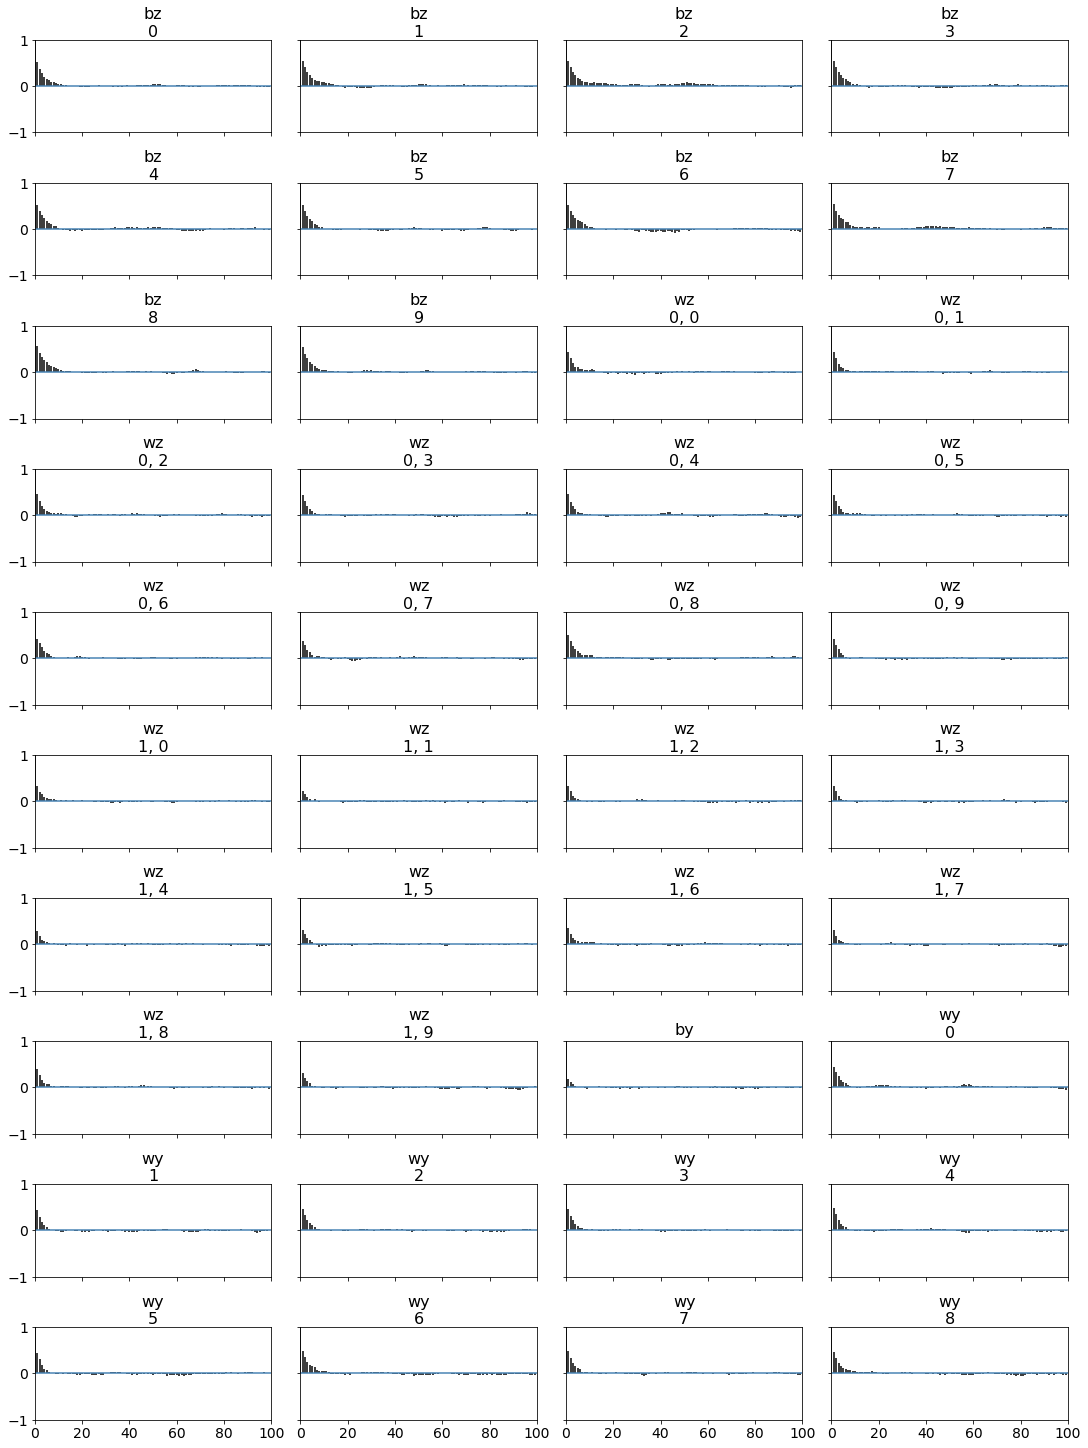

In [84]:
pm.plots.autocorrplot(trace_100_10, figsize=(15, 20), var_names=['bz', 'wz', 'by', 'wy'], combined=True);

## Observaciones

Definimos los priors con el tamaño adecuado para que el funcionamiento de la red sea el adecuado, en este caso "dimos vuelta" las dimensiones de wz y zy para poder efectuar la multiplicación de matrices más adelantes, ya que intentamos trasponer la matriz pero no nos resultó, esta acción no debería generar problemas con el resultado final. Por otro lado, nos guíamos de la siguiente referencia para las especificaciones del modelo: [Bayesian Neural Networks](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html)

In [91]:
#def genera_datos(n_samples):
#  x, y = make_moons(n_samples, # Varie este parámetro
#                  shuffle=True, noise=0.2, random_state=123456)
#  x = (x - np.mean(x, keepdims=True))/np.std(x, keepdims=True)
#  return x,y

In [131]:
with neural_network_s10_M1:
    pm.set_data({"x": x_test})
    posterior_predictive_10_1 = pm.sample_posterior_predictive(trace_10_1, samples=500, var_names=["out"])

100%|██████████| 500/500 [00:03<00:00, 141.17it/s]


In [132]:
with neural_network_s10_M3:
    pm.set_data({"x": x_test})
    posterior_predictive_10_3 = pm.sample_posterior_predictive(trace_10_3, samples=500, var_names=["out"])

100%|██████████| 500/500 [00:04<00:00, 117.64it/s]


In [133]:
with neural_network_s10_M10:
    pm.set_data({"x": x_test})
    posterior_predictive_10_10 = pm.sample_posterior_predictive(trace_10_10, samples=500, var_names=["out"])

100%|██████████| 500/500 [00:06<00:00, 75.17it/s]


In [104]:
with neural_network_s100_M1:
    pm.set_data({"x": x_test})
    posterior_predictive_100_1 = pm.sample_posterior_predictive(trace_100_1, samples=500, var_names=["out"])

100%|██████████| 500/500 [00:03<00:00, 148.04it/s]


In [92]:
with neural_network_s100_M3:
    pm.set_data({"x": x_test})
    posterior_predictive_100_3 = pm.sample_posterior_predictive(trace_100_3, samples=500, var_names=["out"])

100%|██████████| 500/500 [00:04<00:00, 120.05it/s]


In [120]:
with neural_network_s100_M10:
    pm.set_data({"x": x_test})
    posterior_predictive_100_10 = pm.sample_posterior_predictive(trace_100_10, samples=500, var_names=["out"])

100%|██████████| 500/500 [00:06<00:00, 75.91it/s]


# Graficos de la media de los Modelos

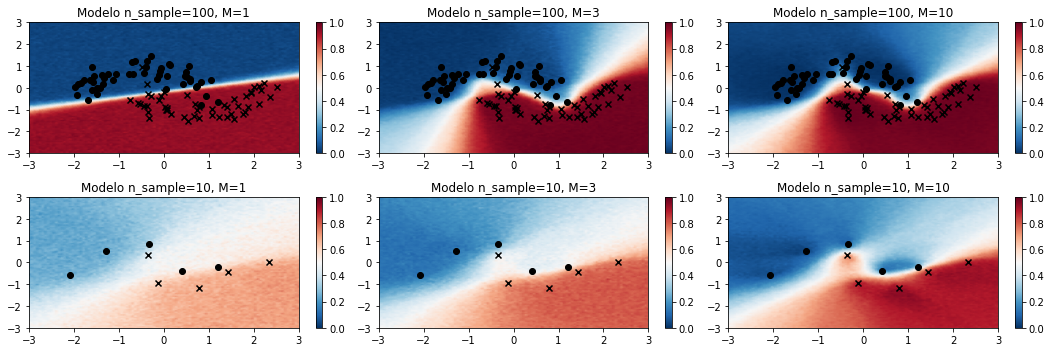

In [157]:
fig, ax = plt.subplots(2,3,figsize=(15, 5), tight_layout=True)
cmap1 = ax[0,0].pcolormesh(x1, x2, np.mean(posterior_predictive_100_1['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
cmap2 = ax[0,1].pcolormesh(x1, x2, np.mean(posterior_predictive_100_3['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
cmap3 = ax[0,2].pcolormesh(x1, x2, np.mean(posterior_predictive_100_10['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
cmap4 = ax[1,0].pcolormesh(x1, x2, np.mean(posterior_predictive_10_1['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
cmap5 = ax[1,1].pcolormesh(x1, x2, np.mean(posterior_predictive_10_3['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)
cmap6 = ax[1,2].pcolormesh(x1, x2, np.mean(posterior_predictive_10_10['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.RdBu_r, shading='gouraud', vmin=0, vmax=1)

plt.colorbar(cmap1, ax=ax[0,0], use_gridspec=True )
plt.colorbar(cmap2, ax=ax[0,1], use_gridspec=True )
plt.colorbar(cmap3, ax=ax[0,2], use_gridspec=True )
plt.colorbar(cmap4, ax=ax[1,0], use_gridspec=True )
plt.colorbar(cmap5, ax=ax[1,1], use_gridspec=True )
plt.colorbar(cmap6, ax=ax[1,2], use_gridspec=True )
ax[0,0].scatter(x_100[y_100==0, 0], x_100[y_100==0, 1], c='k', marker='o')
ax[0,0].scatter(x_100[y_100==1, 0], x_100[y_100==1, 1], c='k', marker='x')
ax[0,1].scatter(x_100[y_100==0, 0], x_100[y_100==0, 1], c='k', marker='o')
ax[0,1].scatter(x_100[y_100==1, 0], x_100[y_100==1, 1], c='k', marker='x')
ax[0,2].scatter(x_100[y_100==0, 0], x_100[y_100==0, 1], c='k', marker='o')
ax[0,2].scatter(x_100[y_100==1, 0], x_100[y_100==1, 1], c='k', marker='x')
ax[1,0].scatter(x_10[y_10==0, 0], x_10[y_10==0, 1], c='k', marker='o')
ax[1,0].scatter(x_10[y_10==1, 0], x_10[y_10==1, 1], c='k', marker='x')
ax[1,1].scatter(x_10[y_10==0, 0], x_10[y_10==0, 1], c='k', marker='o')
ax[1,1].scatter(x_10[y_10==1, 0], x_10[y_10==1, 1], c='k', marker='x')
ax[1,2].scatter(x_10[y_10==0, 0], x_10[y_10==0, 1], c='k', marker='o')
ax[1,2].scatter(x_10[y_10==1, 0], x_10[y_10==1, 1], c='k', marker='x')
ax[0,0].set_title('Modelo n_sample=100, M=1');
ax[0,1].set_title('Modelo n_sample=100, M=3');
ax[0,2].set_title('Modelo n_sample=100, M=10');
ax[1,0].set_title('Modelo n_sample=10, M=1');
ax[1,1].set_title('Modelo n_sample=10, M=3');
ax[1,2].set_title('Modelo n_sample=10, M=10');

# Graficos de la Desviación Estandar de los modelos

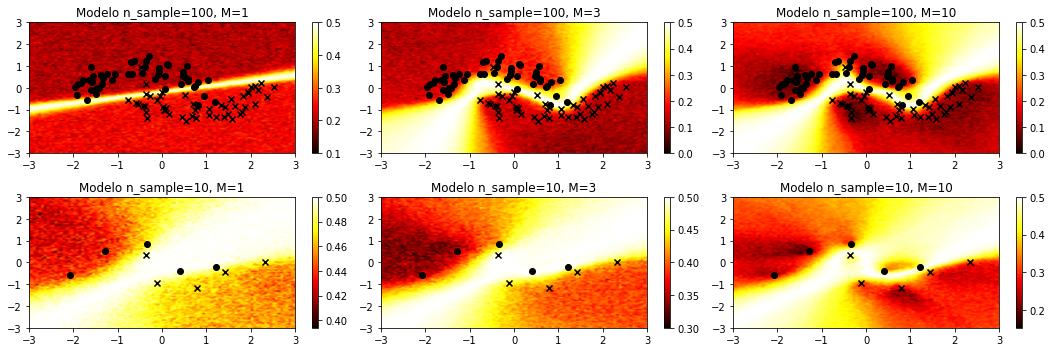

In [229]:
fig, ax = plt.subplots(2,3,figsize=(15, 5), tight_layout=True)
cmap1 = ax[0,0].pcolormesh(x1, x2, np.std(posterior_predictive_100_1['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.hot, shading='gouraud')
cmap2 = ax[0,1].pcolormesh(x1, x2, np.std(posterior_predictive_100_3['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.hot, shading='gouraud')
cmap3 = ax[0,2].pcolormesh(x1, x2, np.std(posterior_predictive_100_10['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.hot, shading='gouraud')
cmap4 = ax[1,0].pcolormesh(x1, x2, np.std(posterior_predictive_10_1['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.hot, shading='gouraud')
cmap5 = ax[1,1].pcolormesh(x1, x2, np.std(posterior_predictive_10_3['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.hot, shading='gouraud')
cmap6 = ax[1,2].pcolormesh(x1, x2, np.std(posterior_predictive_10_10['out'], axis=0).reshape(len(x1), len(x2)), 
                     cmap=plt.cm.hot, shading='gouraud')

plt.colorbar(cmap1, ax=ax[0,0], use_gridspec=True )
plt.colorbar(cmap2, ax=ax[0,1], use_gridspec=True )
plt.colorbar(cmap3, ax=ax[0,2], use_gridspec=True )
plt.colorbar(cmap4, ax=ax[1,0], use_gridspec=True )
plt.colorbar(cmap5, ax=ax[1,1], use_gridspec=True )
plt.colorbar(cmap6, ax=ax[1,2], use_gridspec=True )
ax[0,0].scatter(x_100[y_100==0, 0], x_100[y_100==0, 1], c='k', marker='o')
ax[0,0].scatter(x_100[y_100==1, 0], x_100[y_100==1, 1], c='k', marker='x')
ax[0,1].scatter(x_100[y_100==0, 0], x_100[y_100==0, 1], c='k', marker='o')
ax[0,1].scatter(x_100[y_100==1, 0], x_100[y_100==1, 1], c='k', marker='x')
ax[0,2].scatter(x_100[y_100==0, 0], x_100[y_100==0, 1], c='k', marker='o')
ax[0,2].scatter(x_100[y_100==1, 0], x_100[y_100==1, 1], c='k', marker='x')
ax[1,0].scatter(x_10[y_10==0, 0], x_10[y_10==0, 1], c='k', marker='o')
ax[1,0].scatter(x_10[y_10==1, 0], x_10[y_10==1, 1], c='k', marker='x')
ax[1,1].scatter(x_10[y_10==0, 0], x_10[y_10==0, 1], c='k', marker='o')
ax[1,1].scatter(x_10[y_10==1, 0], x_10[y_10==1, 1], c='k', marker='x')
ax[1,2].scatter(x_10[y_10==0, 0], x_10[y_10==0, 1], c='k', marker='o')
ax[1,2].scatter(x_10[y_10==1, 0], x_10[y_10==1, 1], c='k', marker='x')
ax[0,0].set_title('Modelo n_sample=100, M=1');
ax[0,1].set_title('Modelo n_sample=100, M=3');
ax[0,2].set_title('Modelo n_sample=100, M=10');
ax[1,0].set_title('Modelo n_sample=10, M=1');
ax[1,1].set_title('Modelo n_sample=10, M=3');
ax[1,2].set_title('Modelo n_sample=10, M=10');
